In [54]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches
from scipy import stats
from scipy.stats import skew

from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 100)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout
from keras.optimizers import Adam, Adagrad
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [129]:
sheets = pd.read_excel("Analytics_Case_Data.xlsx", sheet_name=None)

In [130]:
# filling in ...
for sheet_name in sheets.keys():
    sheets[sheet_name] = sheets[sheet_name].ffill(axis = 0)
    #sheets[sheet_name] = pd.to_numeric(sheets[sheet_name], errors='ignore')
    #sheets[sheet_name] = sheets[sheet_name].apply(lambda X: pd.to_numeric(X, errors='ignore'), axis=1)

In [131]:
# Removing the hoist apartments.
sheets['Floor 1'] = sheets['Floor 1'].drop('APT 3', axis=1)
sheets['Floor 2'] = sheets['Floor 2'].drop('APT 4', axis=1)
sheets['Floor 3'] = sheets['Floor 3'].drop('APT 4', axis=1)
sheets['Floor 4'] = sheets['Floor 4'].drop('APT 4', axis=1)
sheets['Floor 5'] = sheets['Floor 5'].drop('APT 4', axis=1)
sheets['Floor 1 (last week)'] = sheets['Floor 1 (last week)'].drop('APT 3', axis=1)
sheets['Floor 2 (last week)'] = sheets['Floor 2 (last week)'].drop('APT 4', axis=1)
sheets['Floor 3 (last week)'] = sheets['Floor 3 (last week)'].drop('APT 4', axis=1)
sheets['Floor 4 (last week)'] = sheets['Floor 4 (last week)'].drop('APT 4', axis=1)
sheets['Floor 5 (last week)'] = sheets['Floor 5 (last week)'].drop('APT 4', axis=1)

In [85]:
today = datetime.strptime('2018-03-31', '%Y-%m-%d')

# Senior manager

The aim of the following analysis is to answer the question *How has the project progressed this week, and are there indications of deep issues?*

The following chart shows the completion ratio of tasks for each floor. (The hoist apartments are not included.) Note that these are the averages of the completion ratios, so the chart does not indicate how many tasks are truly complete (i.e., 100% done).

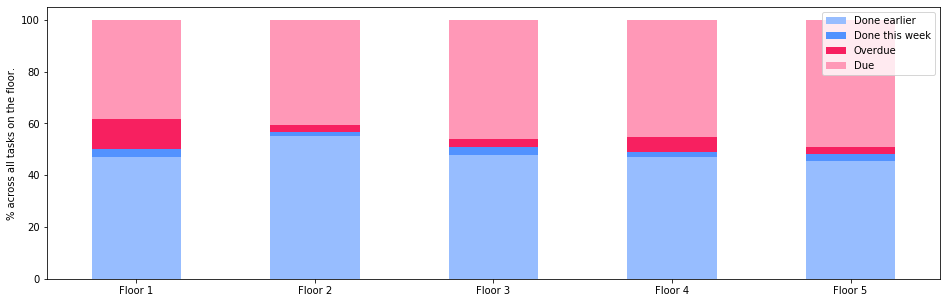

In [141]:
def overdue_ratio(floor):
    
    floor_df = sheets['Floor ' + str(floor)]
    
    # The total amount of tasks on the floor. 4 is taken away from 
    # the amount of columns to yield the amount of APT columns.
    tasks_n = floor_df.shape[0] * (floor_df.shape[1] - 4)
    
    past_deadlines = floor_df[floor_df['PLANNED END'] <= today]
    
    overdues = 0
    for index, row in past_deadlines.iterrows():
        for x in row[4:]:
            if x < 100:
                overdues += 100 - x
    
    return overdues / tasks_n

def done_this_week_ratio(floor):
    current_floor_df = sheets['Floor ' + str(floor)]
    previous_floor_df = sheets['Floor ' + str(floor) + ' (last week)']
    
    tasks_n = current_floor_df.shape[0] * (current_floor_df.shape[1] - 4)
    
    difs_sum = 0
    for name, col in current_floor_df.iloc[:, 4:].iteritems():
        difs_series = current_floor_df[name] - previous_floor_df[name]
        difs_sum += difs_series.sum()
    
    return difs_sum / tasks_n

def complete_ratio(floor):
    df = sheets['Overall']
    return df['FLOOR ' + str(floor)].mean()

    
complete_ratios = []
done_this_week_ratios = []
due_ratios = []
overdue_ratios = []
for i in range(5):
    c, d, o = complete_ratio(i+1), done_this_week_ratio(i+1), overdue_ratio(i+1)
    complete_ratios.append(c - d), done_this_week_ratios.append(d), overdue_ratios.append(o), due_ratios.append(100 - c - o)

floors = ['Floor ' + str(i+1) for i in range(5)]

barplot_df = pd.DataFrame(list(zip(complete_ratios, 
                                   done_this_week_ratios, 
                                   overdue_ratios, 
                                   due_ratios)), 
                          columns=['Done earlier', 'Done this week', 'Overdue', 'Due'], index=floors)

barplot_df.plot(kind='bar', stacked=True, legend=False, color=['#97BDFF', '#5292FF', '#F72060', '#FF98B7'], figsize=(16,5))
plt.xticks(rotation=0)
plt.ylabel('% across all tasks on the floor.')
_ = plt.legend(loc="upper right")

The mean amount of tasks that were done this week (not necessarily completed, but done to some degree) is around **2.4%**. If this weekly speed persists, the project would take about 18 more weeks.

Unfortunately all floors have overdue tasks, with a mean of around **5%** across the floors. Floor 1 is in particularly bad shape, with as much as **12%** overdue, despite the fact that Floor 1 was begun the earliest and has the least amount of apartments. 

# Construction manager

The aim of the following analysis is to answer the question *What is the state of each floor, and are there indications of egregious redundancies?* 

To answer it, below is a heatmap for each floor, showing the latest completion ratio of each task (excluding those of the hoist apartments). The cells representing overdue tasks have been outlined in red. (The taskgroups **Flooring Installation**; **Apartment Final Decoration**; and **Commission + Inspect** have been omitted, since none of their tasks have been started on any floor, while the taskgroups **Apartment core** and **M&E 1st Fix and Pod Positioning** have been omitted because they are 100% complete on every floor.)

**General observations**

1. For some reason, the *Internal Walls Structure & Boarding* task is unfinished in Apartment 1 in three of the floors, without any progress from last week. Though this may be due to those apartments' special locations, so that some spatial dependency has up to now prevented finishing them, it may be worth checking out the cause anyway.  
2. 


In [174]:
omit_taskgroups = ['Flooring Installation, Kitchen Units ',
                   'Apartment Final Decoration',
                   'Commission + Inspect',
                   'Apartment Core',
                   'M&E 1st Fix and Pod Positioning'
                  ]

def floor_heatmap(floor):
    fig = plt.figure(figsize=(17,6), dpi=150)

    floor_df = sheets['Floor ' + str(floor)]
    for taskgroup in omit_taskgroups:
        floor_df = floor_df[floor_df['TASKGROUP'] != taskgroup]

    past_deadlines = floor_df[floor_df['PLANNED END'] <= today]
    #next_week_deadlines = matrix[(matrix['PLANNED END'] > today)
    #                           & (matrix['PLANNED END'] < today + timedelta(days=7))]
    
    overdues = past_deadlines.iloc[:, 4:] < 100
    #due_next_week = next_week_deadlines.iloc[:, 4:]
    
    floor_df = floor_df.drop(['TASKGROUP', 'PLANNED START', 'PLANNED END'], axis=1)
    floor_df = floor_df.set_index('TASK')
    ax = sns.heatmap(floor_df.T, cmap='Blues', cbar_kws={'label': '% complete'})

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title('Floor {} task completion'.format(floor), fontsize=20, pad=15)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    
    from matplotlib.patches import Rectangle
    for index, x in np.ndenumerate(overdues):
        if x:
            ax.add_patch(Rectangle((index[0], index[1]), 1, 1, fill=False, edgecolor='red', lw=2))
    #for index, x in np.ndenumerate(due_next_week):
    #    if x:
    #        ax.add_patch(Rectangle((index[0], index[1]), 1, 1, fill=False, edgecolor='yellow', lw=2))

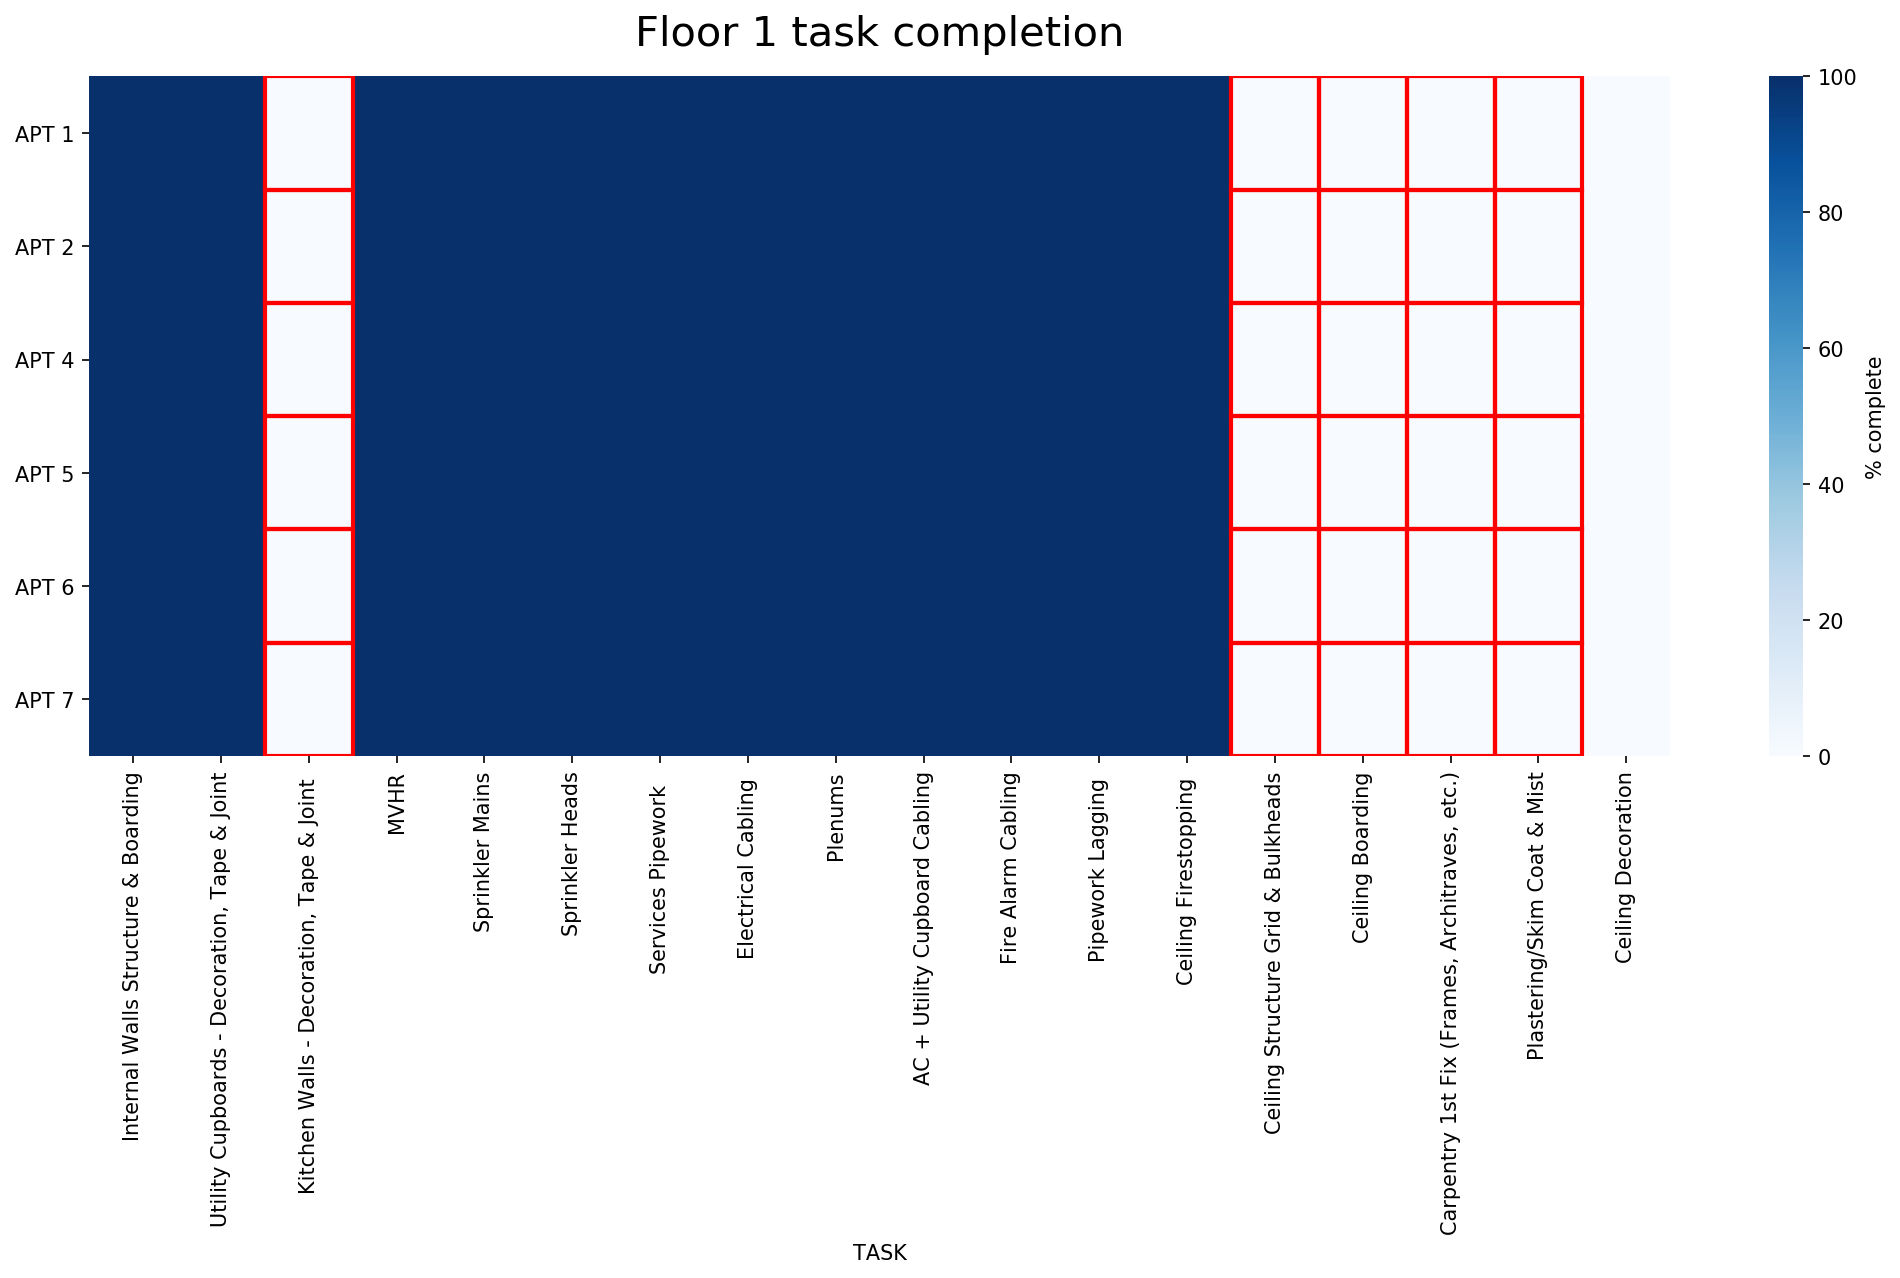

In [175]:
floor_heatmap(1)

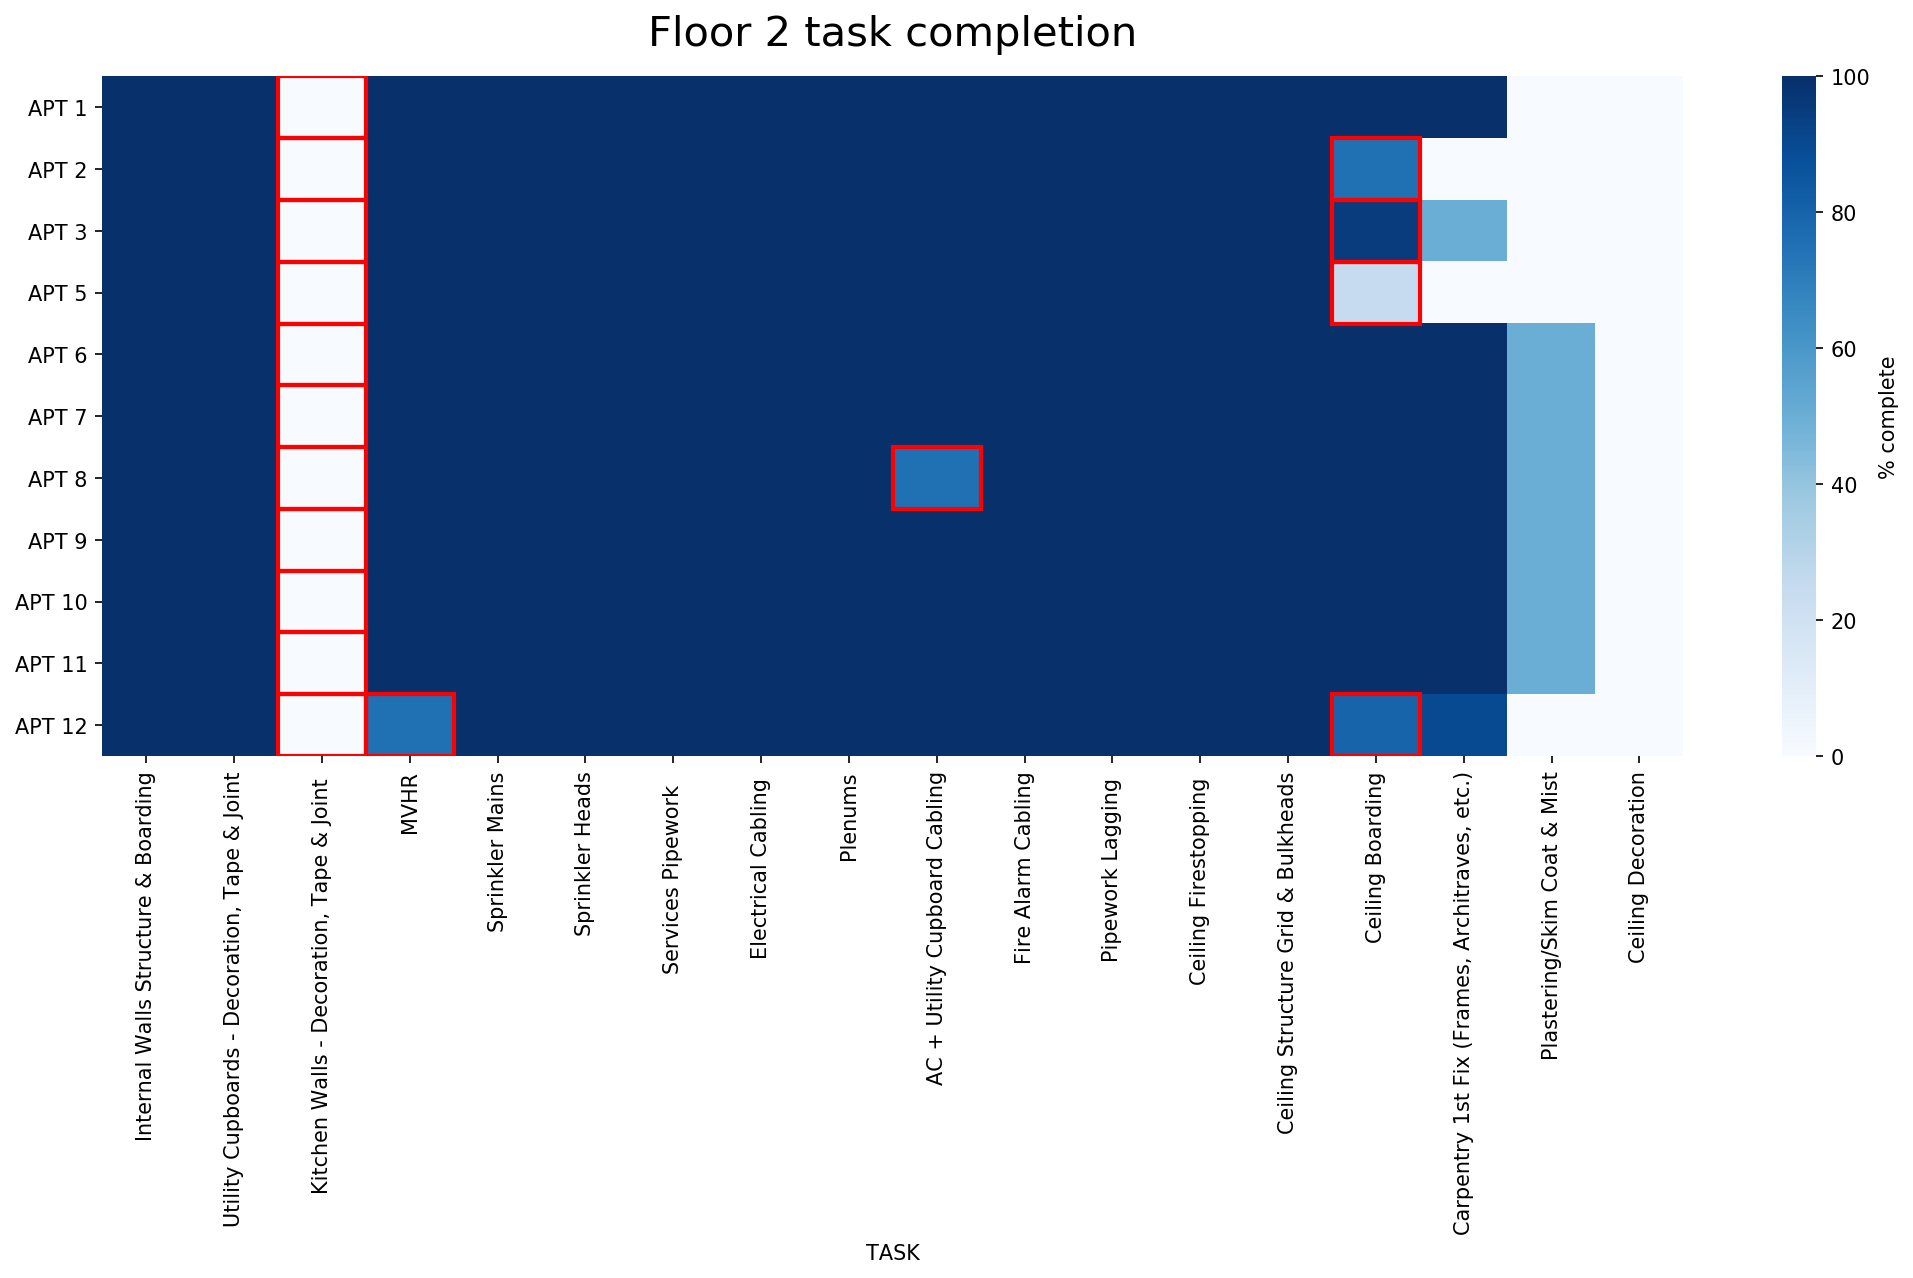

In [176]:
floor_heatmap(2)

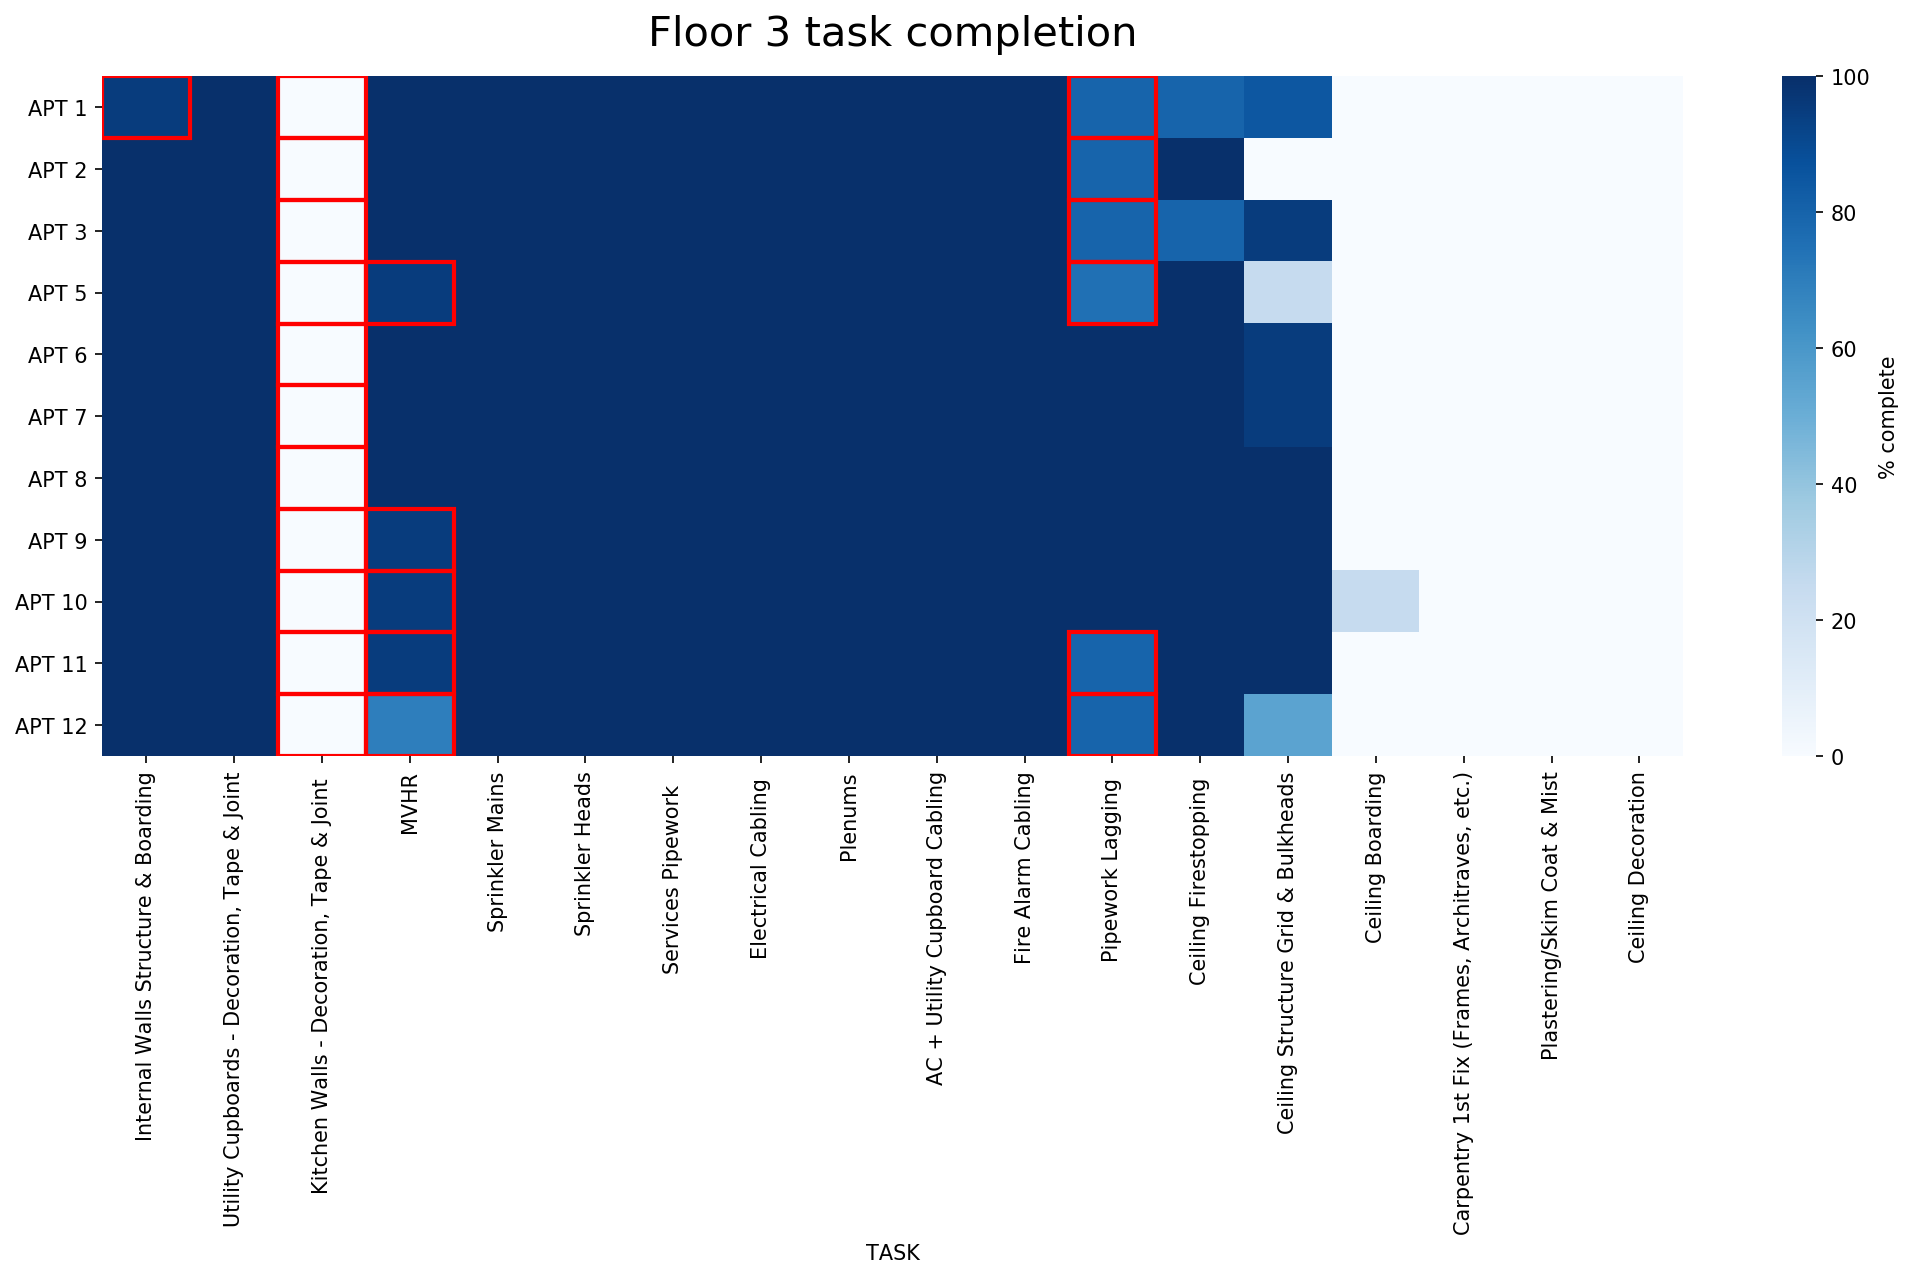

In [177]:
floor_heatmap(3)

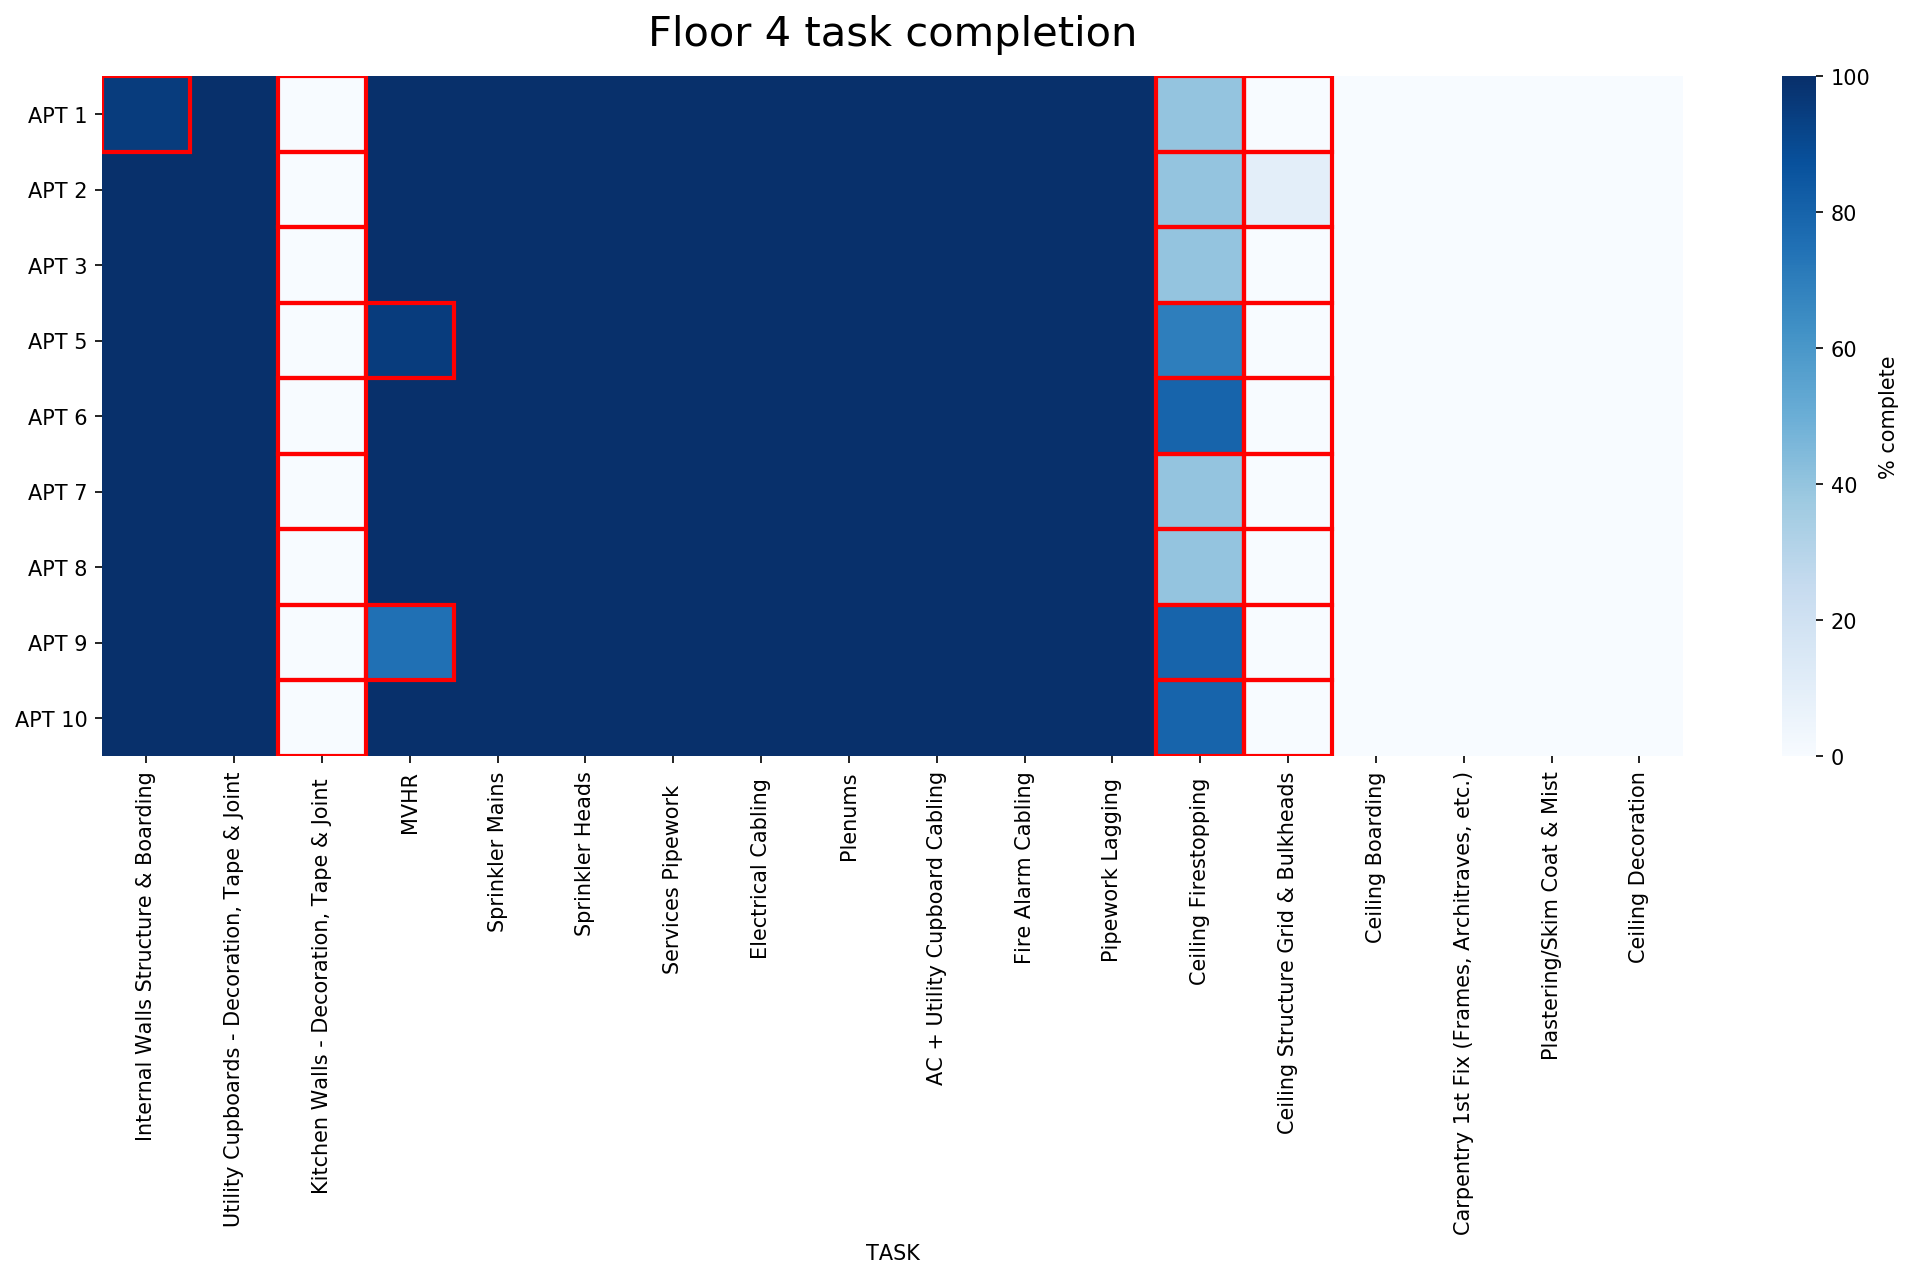

In [178]:
floor_heatmap(4)

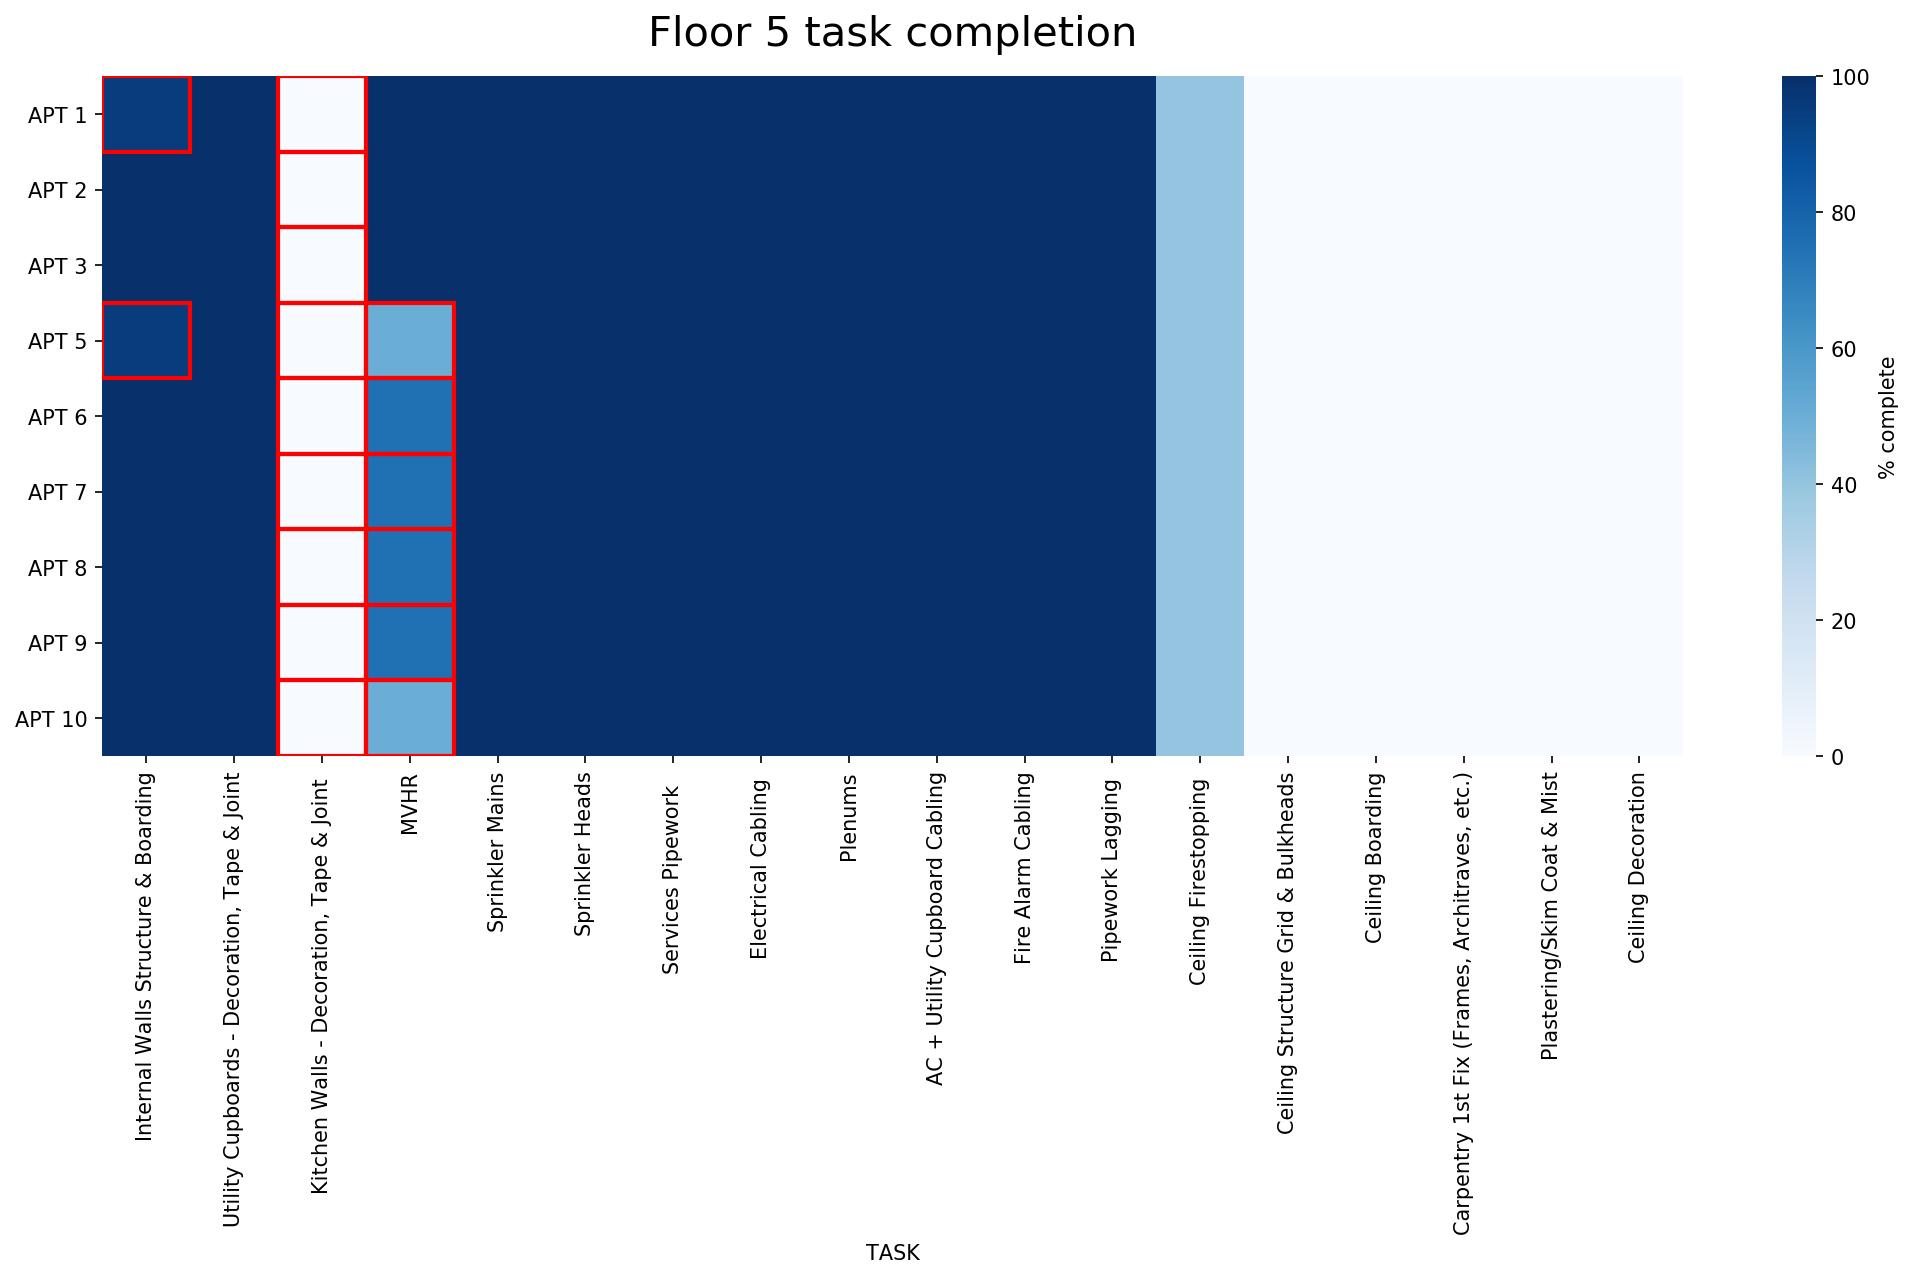

In [179]:
floor_heatmap(5)

# Subcontractor manager

In [221]:
def apartment_imps(taskgroup):
    
    for i in range(5):    
        current_floor_df = sheets['Floor ' + str(i+1)]
        previous_floor_df = sheets['Floor ' + str(i+1) + ' (last week)']
        
        # Using only the numeric columns.
        current_floor_df = current_floor_df.iloc[:,4:] 
        previous_floor_df = previous_floor_df.iloc[:,4:] 

        difs_series = current_floor_df.subtract(previous_floor_df)

        if difs_series.sum() != 0:
            previous_floor_df['Difs'] = difs_series
            previous_floor_df = previous_floor_df.iloc[difs_series.to_numpy().nonzero()[0], :]
            barplot_df = previous_floor_df[['TASK', apt_str, 'Difs']].set_index('TASK')
            #barplot_df.plot(kind='bar', stacked=True, legend=False, ax=ax, color=['#F79EAD', '#F30F35'])
        
apartment_imps('Apartment Core')

In [ ]:
def difs(floor):
    current_floor_df = sheets['Floor ' + str(floor)]
    previous_floor_df = sheets['Floor ' + str(floor) + ' (last week)']

    # Using only the numeric columns.
    current_floor_df = current_floor_df.iloc[:,4:] 
    previous_floor_df = previous_floor_df.iloc[:,4:] 

    difs = current_floor_df.subtract(previous_floor_df)
    return difs

def apartment_imps(taskgroup):
    
    for i in range(1):    
        difs_df = difs(i+1)
        difs_df = difs_df['TASKGROUP' == taskgroup]

        if difs_df.any():
            previous_floor_df['Difs'] = difs_series
            previous_floor_df = previous_floor_df.iloc[difs_series.to_numpy().nonzero()[0], :]
            barplot_df = previous_floor_df[['TASK', apt_str, 'Difs']].set_index('TASK')
            barplot_df.plot(kind='bar', stacked=True, legend=False, ax=ax, color=['#F79EAD', '#F30F35'])
        
apartment_imps('Apartment Core')

# Improvements

Relationships between tasks. Proper planning analysis. e.g. the reason why the task *Kitchen Walls - Decoration, Tape & Joint* has not been started on any floor despite being overdue may well be explained by a dependency.

Also with more weeks, could find patterns of inefficiency:
    1. Where certain tasks are not being done for long times.
    2. Which subcontractors have lost speed.
    3. Having gained speed, could probe into reasons in order to propagate the improvements.
